In [21]:
#Importing all the necessary libraries
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

Question 1: Read and explore the dataset. (Rename column, plot histograms, find data characteristics)

In [49]:
#Import the data set
df = pd.read_csv('ratings_Electronics.csv', header=None)
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']
df = df.drop('timestamp', axis=1)
df_copy = df.copy(deep=True)

In [50]:
df.tail()

,user_id,prod_id,rating
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.0
7824478,A322MDK0M89RHN,BT008UKTMW,5.0
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.0
7824481,A2G81TMIOIDEQQ,BT008V9J9U,5.0


In [51]:
# Check the number of rows and columns
rows, columns = df.shape
print("No of rows: ", rows) 
print("No of columns: ", columns)

No of rows:  7824482
No of columns:  3


In [52]:
#Check Data types
df.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

In [53]:
# Check for missing values present
print('Number of missing values across columns-\n', df.isnull().sum())

Number of missing values across columns-
 user_id    0
prod_id    0
rating     0
dtype: int64


No missing values

In [54]:
# Summary statistics of 'rating' variable
df[['rating']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rating,7824482.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


In [55]:

# find minimum and maximum ratings 

def find_min_max_rating():
    print('The minimum rating is: %d' %(df['rating'].min()))
    print('The maximum rating is: %d' %(df['rating'].max()))
    
find_min_max_rating()

The minimum rating is: 1
The maximum rating is: 5


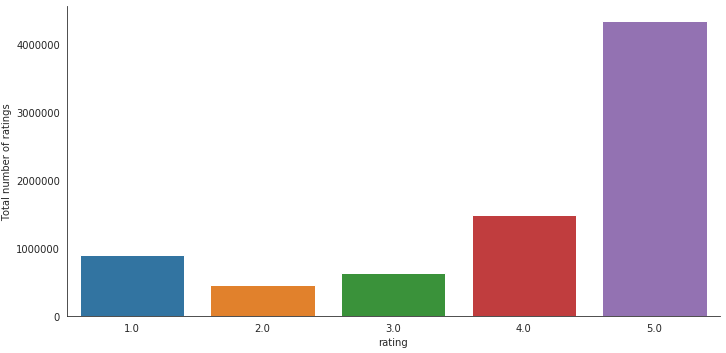

In [56]:
# Check the distribution of ratings 
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [57]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  4201696
Number of unique ITEMS in Raw data =  476002


Question 2: Take subset of dataset to make it less sparse/more dense. 
    (For example, keep the users only who has given 50 or more number of ratings )

In [58]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

In [59]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

In [60]:
print('Number of users who have rated 50 or more items =', len(df_final))
print('Number of unique USERS in final data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in final data = ', df_final['prod_id'].nunique())

Number of users who have rated 50 or more items = 125871
Number of unique USERS in final data =  1540
Number of unique ITEMS in final data =  48190


df_final has users who have rated 50 or more items

In [61]:
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


In [62]:
final_ratings_matrix.tail()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
AZBXKUH4AIW3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZCE11PSTCH1L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZMY6E8B52L2T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZNUHQSHZHSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZOK5STV85FBJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

user_id,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
prod_id,,,,,,,,,,,,,,,,,,,,,
0594451647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0594481813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0970407998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Question 3: Split the data randomly into train and test dataset. (For example split it in 70/30 ratio)

In [64]:
#Split the training and test data in the ratio 70:30
train_data, test_data = train_test_split(amazon_new_df, test_size = 0.3, random_state=0)

print(train_data.head(5))

          index         user_id  product_id  rating
24401   1374364  A1S7BFT0HDF3HA  B000TO1SMG     4.0
83993   5343006  A1J75JJ0Q2OEJN  B0069QZ676     4.0
33140   1903477   AGVWTYW0ULXHT  B001CHHVCU     3.0
19305   1060012   ABXANRX4GPYRZ  B000IV413S     5.0
108110  7187913  A1XE3M22N91451  B00BXA7N6A     5.0


In [65]:
print("Test data shape: ", test_data.shape)
print("Train data shape: ", train_data.shape)

Test data shape:  (36652, 4)
Train data shape:  (85519, 4)


Question 4: Build Popularity Recommender model.     

In [66]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('product_id').agg({'user_id': 'count'}).reset_index()
train_data_grouped.rename(columns = {'user_id': 'score'},inplace=True)
train_data_grouped.head()

,product_id,score
0,0594481813,1
1,0970407998,2
2,0972683275,2
3,1400501466,3
4,1400501520,1


In [67]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'product_id'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,product_id,score,Rank
30197,B0088CJT4U,150,1.0
19162,B003ES5ZUU,130,2.0
8448,B000N99BBC,112,3.0
29619,B007WTAJTO,104,4.0
29901,B00829TIEK,104,5.0


In [68]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['user_id'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [69]:
find_recom = [15,121,200]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n")

Here is the recommendation for the userId: 15

       user_id  product_id  score  Rank
30197       15  B0088CJT4U    150   1.0
19162       15  B003ES5ZUU    130   2.0
8448        15  B000N99BBC    112   3.0
29619       15  B007WTAJTO    104   4.0
29901       15  B00829TIEK    104   5.0


Here is the recommendation for the userId: 121

       user_id  product_id  score  Rank
30197      121  B0088CJT4U    150   1.0
19162      121  B003ES5ZUU    130   2.0
8448       121  B000N99BBC    112   3.0
29619      121  B007WTAJTO    104   4.0
29901      121  B00829TIEK    104   5.0


Here is the recommendation for the userId: 200

       user_id  product_id  score  Rank
30197      200  B0088CJT4U    150   1.0
19162      200  B003ES5ZUU    130   2.0
8448       200  B000N99BBC    112   3.0
29619      200  B007WTAJTO    104   4.0
29901      200  B00829TIEK    104   5.0




In [70]:
print('Since this is a popularity-based recommender model, recommendations remain the same for all users')
print('\nWe predict the products based on the popularity. It is not personalized to particular user')

Since this is a popularity-based recommender model, recommendations remain the same for all users

We predict the products based on the popularity. It is not personalized to particular user


# Question 5: Build Collaborative Filtering model.

In [71]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.tail()

,level_0,index,user_id,product_id,rating
122166,37310,2152352,A1TY97ZGQT5FGF,B001MT988I,1.0
122167,116126,7623917,A2NYK9KWFMJV4Y,B00FDKAS72,5.0
122168,95728,6257454,A3FEGTOLCWXSV4,B008J127IA,4.0
122169,54970,3268076,AAQ9NJ480N9W5,B003DZ165W,5.0
122170,67105,4091526,A18EA7MNLXP9H5,B004G603E2,4.0


In [72]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df = df_CF.pivot(index = 'user_id', columns ='product_id', values = 'rating').fillna(0)
print(pivot_df.shape)
pivot_df.head()

(1466, 47155)


product_id,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

product_id,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,...,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_index
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [74]:
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

product_id,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


SVD Method it is best to apply on sparse matrix

In [75]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 50)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

SVD is useful in many tasks, such as data compression, noise reduction similar to Principal Component Analysis and Latent Semantic Indexing (LSI), 
used in document retrieval and word similarity in Text mining

In [76]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

product_id,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.001588,0.002451,-0.035895,0.004397,0.006706,0.021698,0.000436,0.008206,0.005558,-0.002057,...,0.000167,-0.058767,0.001375,-0.123896,0.025795,0.015849,0.002735,-0.176885,0.005937,-0.012155
1,-0.011001,0.000095,0.109788,0.010875,-0.003261,0.063178,-0.000852,0.016883,-0.002354,0.026892,...,-0.000023,0.010536,0.001531,0.021341,-0.041795,0.004579,0.002491,-0.026376,-0.018861,0.039145
2,-0.002794,-0.007663,0.007355,0.005759,-0.003735,-0.002737,0.007006,-0.007418,-0.002495,0.005797,...,-0.001553,-0.042050,0.000247,-0.053062,0.018583,-0.005048,-0.002397,0.078739,-0.116666,0.002829
3,0.011624,-0.006947,-0.011842,-0.001235,0.002217,-0.005592,-0.001605,0.002655,0.001673,0.001937,...,0.000576,-0.007289,0.000048,-0.047540,0.022800,0.006261,0.003486,0.005810,-0.017581,-0.025673
4,-0.002654,0.011595,0.020182,0.009237,0.005416,0.016867,0.003852,0.003173,0.005134,0.018685,...,0.000205,0.020602,0.000892,-0.022049,-0.012444,0.001050,0.000947,-0.021427,0.011899,0.013891


In [77]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [78]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 121
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 121):

                   user_ratings  user_predictions
Recommended Items                                
B007WTAJTO                  0.0          0.540214
B00E3W15P0                  0.0          0.246001
B003ES5ZUU                  0.0          0.221612
B009SYZ8OC                  0.0          0.175769
B000HPV3RW                  0.0          0.173167


Question 6 : Evaluate both the models. (Once the model is trained on the training data, 
            it can be used to compute the error (RMSE) on predictions made on the test data.)

In [79]:
# Actual ratings given by the users
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:

# Predicted ratings 
preds_df.head()

product_id,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.001588,0.002451,-0.035895,0.004397,0.006706,0.021698,0.000436,0.008206,0.005558,-0.002057,...,0.000167,-0.058767,0.001375,-0.123896,0.025795,0.015849,0.002735,-0.176885,0.005937,-0.012155
1,-0.011001,0.000095,0.109788,0.010875,-0.003261,0.063178,-0.000852,0.016883,-0.002354,0.026892,...,-0.000023,0.010536,0.001531,0.021341,-0.041795,0.004579,0.002491,-0.026376,-0.018861,0.039145
2,-0.002794,-0.007663,0.007355,0.005759,-0.003735,-0.002737,0.007006,-0.007418,-0.002495,0.005797,...,-0.001553,-0.042050,0.000247,-0.053062,0.018583,-0.005048,-0.002397,0.078739,-0.116666,0.002829
3,0.011624,-0.006947,-0.011842,-0.001235,0.002217,-0.005592,-0.001605,0.002655,0.001673,0.001937,...,0.000576,-0.007289,0.000048,-0.047540,0.022800,0.006261,0.003486,0.005810,-0.017581,-0.025673
4,-0.002654,0.011595,0.020182,0.009237,0.005416,0.016867,0.003852,0.003173,0.005134,0.018685,...,0.000205,0.020602,0.000892,-0.022049,-0.012444,0.001050,0.000947,-0.021427,0.011899,0.013891


In [81]:
# Average PREDICTED rating for each item
preds_df.mean().head()

product_id
0594481813    0.002948
0970407998    0.003437
0972683275    0.009239
1400501466    0.004098
1400501520    0.001890
dtype: float64

In [82]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
0594451647,0.003247,NaN,0
0594481813,0.001948,0.002948,1
0970407998,0.003247,0.003437,2
0972683275,0.012338,0.009239,3
1400501466,0.012987,0.004098,4


In [83]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.00289 



Question 7: Get top - K (K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits,we will recommend 5 new products.

In [84]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 200
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 200):

                   user_ratings  user_predictions
Recommended Items                                
B0088CJT4U                  0.0          0.900405
B002R5AM7C                  0.0          0.742282
B00829TIA4                  0.0          0.572265
B004CLYEDC                  0.0          0.506008
B003CFATT2                  0.0          0.457608


Question 8: Summarise your insights.

Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be not suitable to the user.You can see the differance above for the user id 121 & 200, The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history